Para realizar a análise, regressão e classificação, escolhemos o dataset Housing Prices, disponível em:

https://www.kaggle.com/datasets/yasserh/housing-prices-dataset

O dataset é composto por apenas 1 arquivo .csv separado por vírgulas (",")
O arquivo contém 13 colunas, sendo o objetivo realizar a regressão para inferir o preço das casas e realizar a classificação para inferir quais casas possuem sala de visitas.

1) importar as dependências necessárias

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler

2) leitura do arquivo

In [38]:
df = pd.read_csv('Housing.csv', delimiter=',', header=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


3) limpeza de dados indesejados

In [39]:
df_cp = df.copy()
df_cp = df_cp.drop_duplicates()
obj_cols = [col for col in df_cp.columns if df_cp[col].dtype == 'object']
# para colunas de valor booleano (sim ou não) devem existir apenas 2 tipos de resposta, furnishingstatus deve possuir 3 valores
print(f"Valores repetidos:\n{df_cp[obj_cols].nunique()}")

# caso exista valores fora do padrão, devem ser substituidos
valores_aceitos = ['yes', 'no']
valores_furnishingstatus = ['furnished', 'semi-furnished', 'unfurnished']

for col in df_cp.columns:
    if col in obj_cols:
        if col == 'furnishingstatus':
            df_cp[col] = df_cp[col].apply(lambda x: x if x in valores_furnishingstatus else 'unfurnished')
        else:
            df_cp[col] = df_cp[col].apply(lambda x: x if x in valores_aceitos else 'no')
    else:
        df_cp[col] = df_cp[col].fillna(df_cp[col].median())


print(f"\n\nValores faltantes:\n{df_cp.isnull().sum()}")

Valores repetidos:
mainroad            2
guestroom           2
basement            2
hotwaterheating     3
airconditioning     2
prefarea            2
furnishingstatus    3
dtype: int64


Valores faltantes:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


4) Transformação dos dados de atributos qualitativos para quantitativos

In [40]:
# transformação de dados qualitativos em quantitativos
le = LabelEncoder()
for col in obj_cols:
  df_cp[col] = le.fit_transform(df_cp[col])


5) mostrar a correlação entre colunas

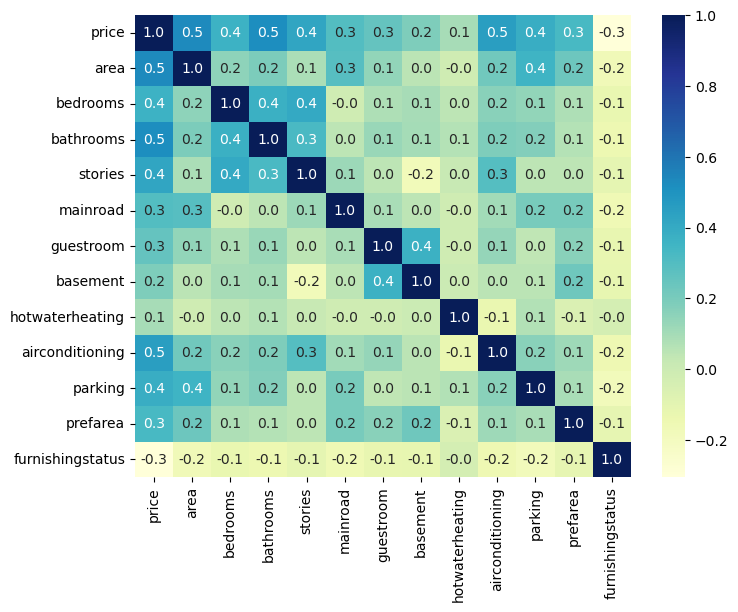

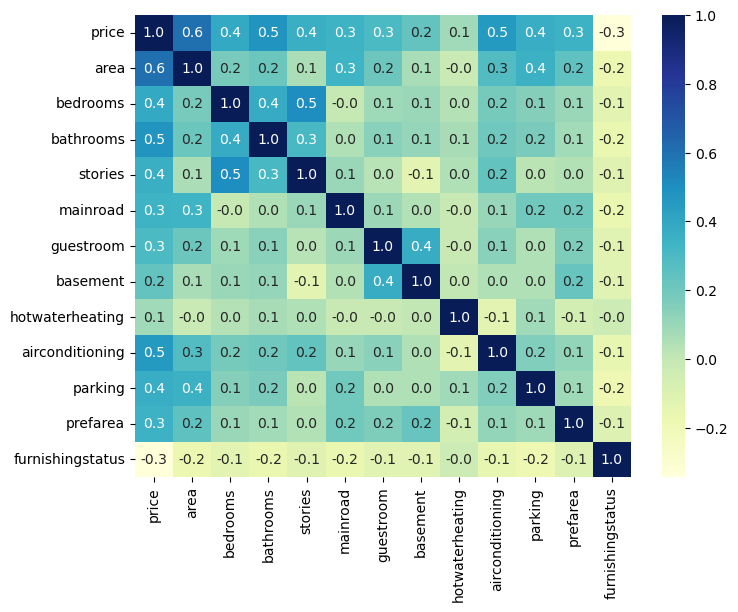

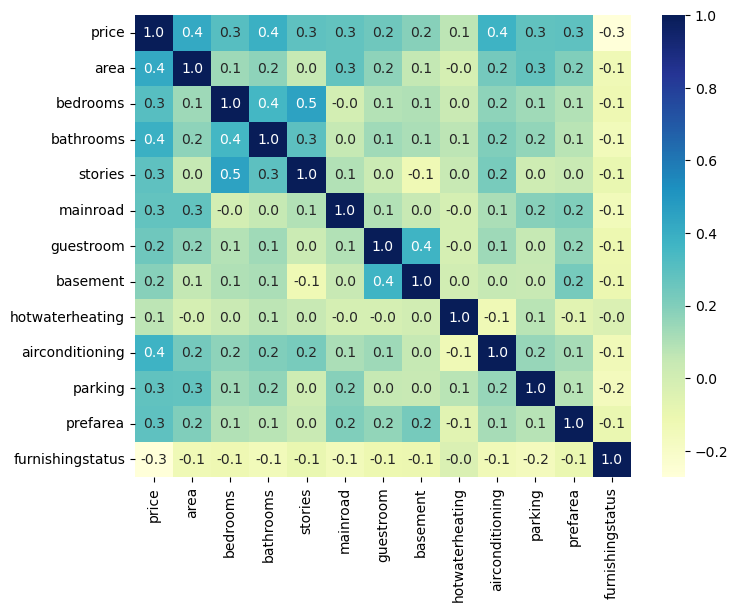

In [41]:
# plot do mapa de calor de correlação
corr_person = df_cp.corr(method='pearson')
corr_sperman = df_cp.corr(method='spearman')
corr_kendall = df_cp.corr(method='kendall')
corr_list = [corr_person, corr_sperman, corr_kendall]
for corr in corr_list:
  plt.figure(figsize=(8, 6))
  sns.heatmap(corr, cmap="YlGnBu", annot=True, fmt=".1f")

É possível verificar que Price possui índices de correlação rasoáveis e Guestroom possui índices de correlação baixos.

No geral, isso pode implicar em melhor acurácia para regressão do campo Price e pior acurácia para a classificação do campo Guestroom

Para a redução de dimensionalidade, é escolhido remover o campo com menor correlação para as colunas alvo (hotwaterheating), que possui correlação 0 com o campo guestroom e correlação 0.1 com o campo price.


In [42]:
del df_cp['hotwaterheating']

6) Análise descritiva

In [43]:
df_cp[["price","area"]].describe()

,price,area
count,5.450000e+02,545.000000
mean,4.766729e+06,5150.541284
std,1.870440e+06,2170.141023
min,1.750000e+06,1650.000000
25%,3.430000e+06,3600.000000
50%,4.340000e+06,4600.000000
75%,5.740000e+06,6360.000000
max,1.330000e+07,16200.000000


/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

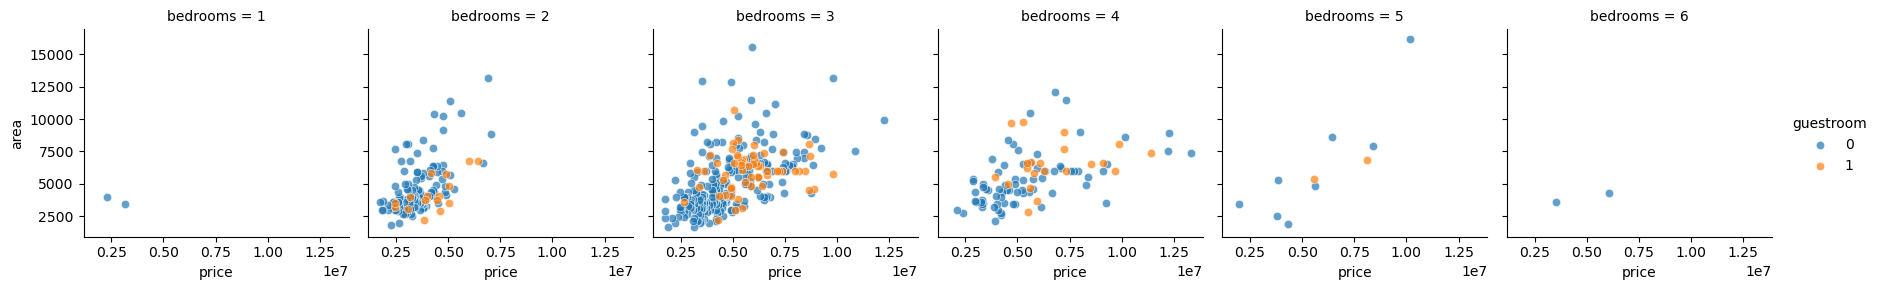

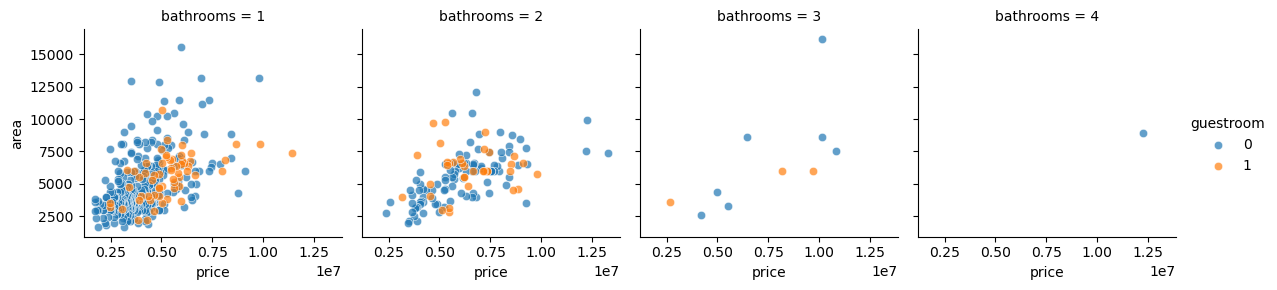

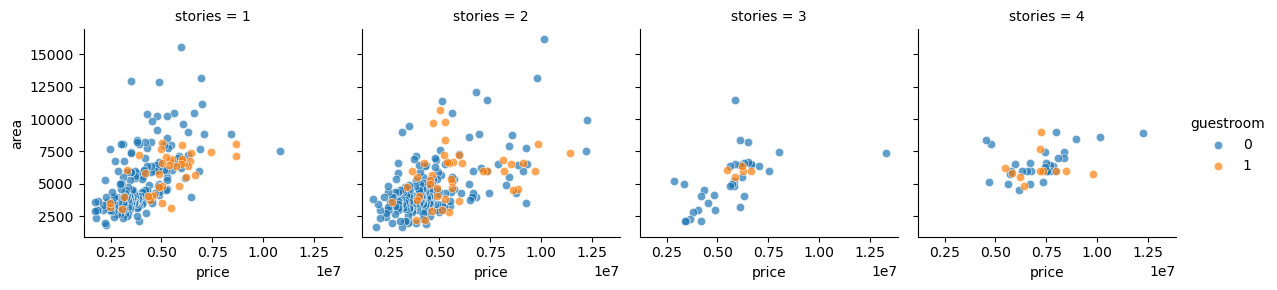

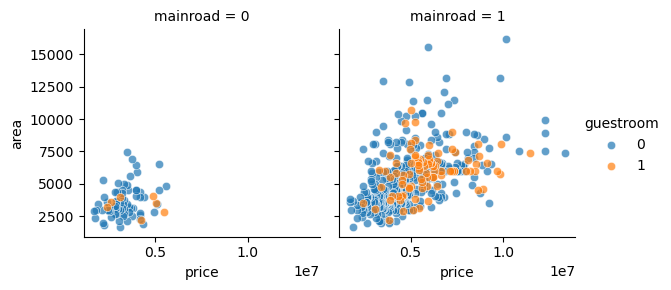

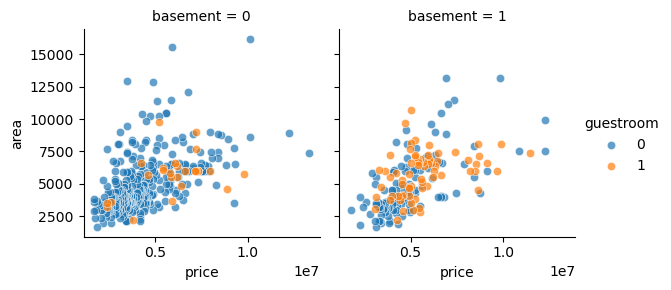

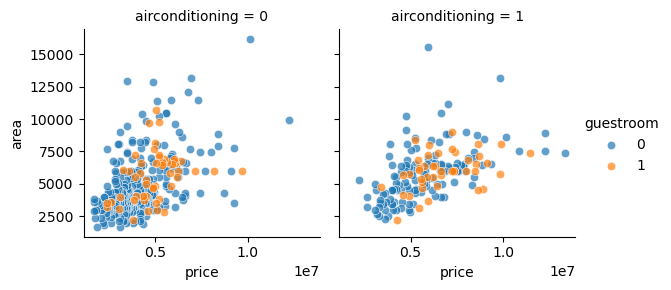

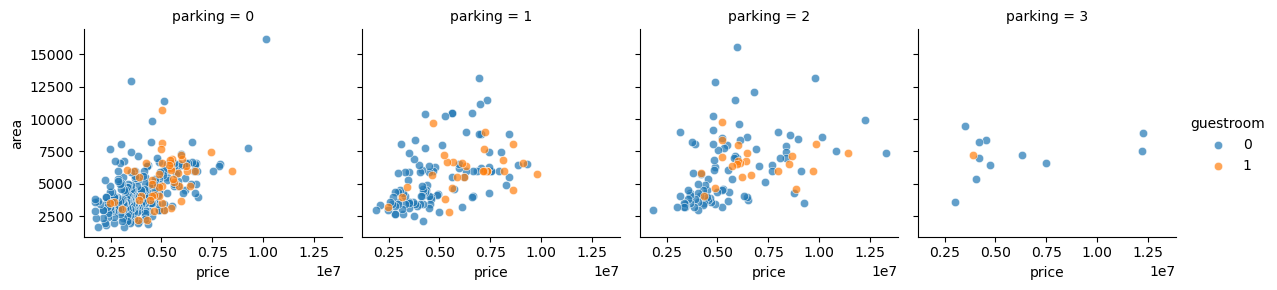

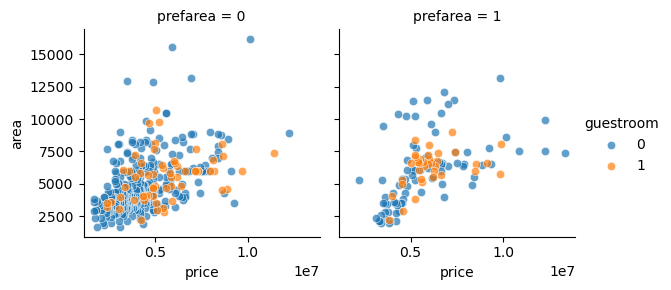

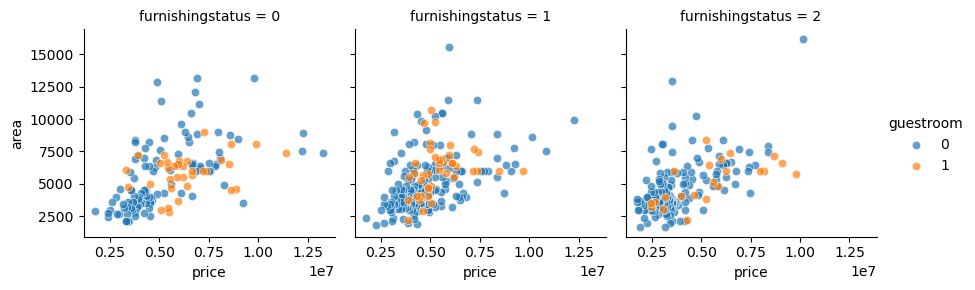

In [44]:
colunas_alvo = ['bedrooms','bathrooms','stories','mainroad','basement','airconditioning','parking','prefarea','furnishingstatus']
for col in colunas_alvo:
  g = sns.FacetGrid(df_cp, col=col, hue="guestroom")
  g.map(sns.scatterplot, "price", "area", alpha=.7)
  g.add_legend()

/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

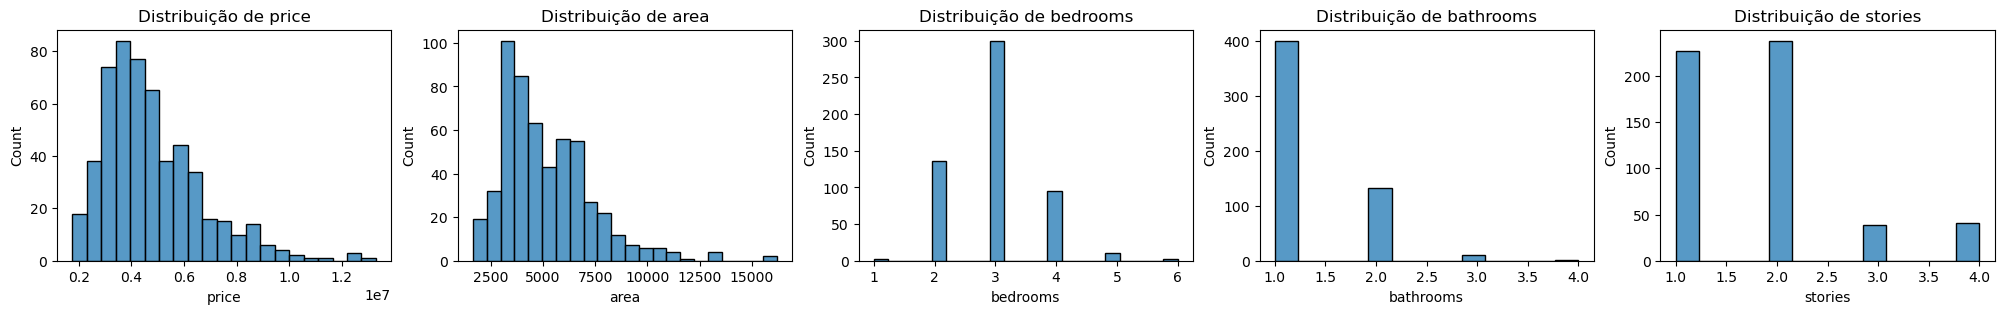

In [45]:
colunas_alvo = ["price","area","bedrooms","bathrooms","stories"]
fig, axs = plt.subplots(ncols=5, figsize=(25,3))
for i, col in enumerate(colunas_alvo):
  axs[i].set_title(f'Distribuição de {col}')
  sns.histplot(df_cp, x=col, ax=axs[i])


Com os gráficos plotados, podemos verificar que os dados não possuem muita correlação com "guestroom". Também nota-se que o preço é um dos melhores índices relacionados a guestrooms, já que pela tendência, casas mais baratas não possuem sala de visitas. Mas essa métrica não será levada em conta na classificação, uma vez que price também é um campo alvo. Devido a dificuldade de separar casas com guestroom nestes gráficos plotados, a classificação da coluna pode ter desempenho prejudicado, ou para ser nítido a relação de guestroom, seria necessário compreender todas as variáveis, o que não é possível de plotar.

Outro ponto é que as variáveis quantitativas do dataset seguem a distribuição normal, o que é um bom sinal e é esperado. A padronização é um bom cadidato para este conjunto de dados, por conta do que foi pontuado aqui.

7) Descobrir se existem outliers nas colunas

/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


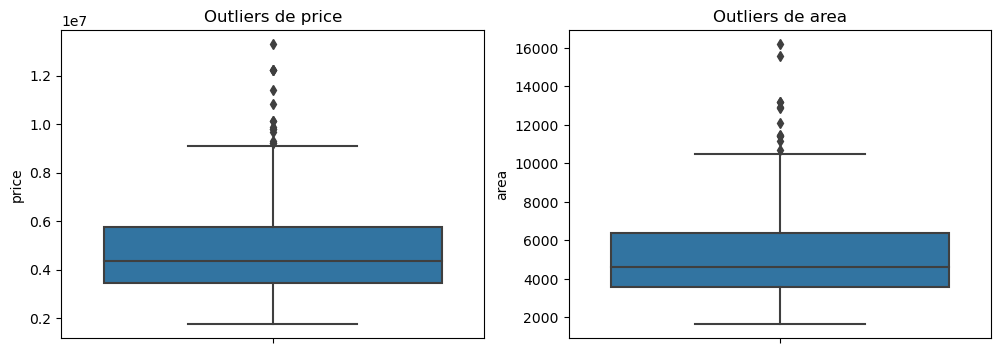

In [46]:
colunas_alvo = ["price","area"]
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
for i, col in enumerate(colunas_alvo):
  axs[i].set_title(f'Outliers de {col}')
  sns.boxplot(df_cp, y=col, ax=axs[i])


É possível perceber que existem outliers em ambas as colunas. Mas por serem valores aceitáveis, mesmo que altos, serão mantidos para a análise final.

Para fins de demonstração, o código para remoção dos outliers é implementado.

/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


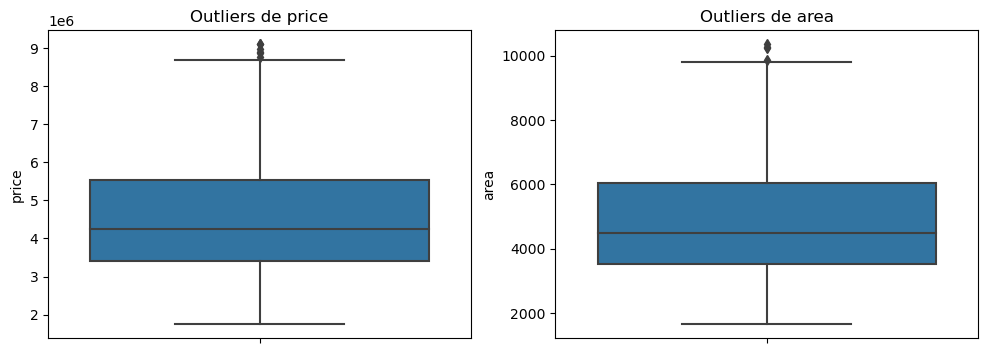

In [61]:
colunas_alvo = ["price","area"]
df_clean = df_cp.copy()
for col in colunas_alvo:
  Q1 = df_clean[col].quantile(0.25)
  Q3 = df_clean[col].quantile(0.75)
  IQR = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IQR
  limite_superior = Q3 + 1.5 * IQR
  df_clean = df_clean[(df_clean[col] >= limite_inferior) & (df_clean[col] <= limite_superior)]

fig, axs = plt.subplots(ncols=2, figsize=(12,4))
for i, col in enumerate(colunas_alvo):
  axs[i].set_title(f'Outliers de {col}')
  sns.boxplot(df_clean, y=col, ax=axs[i])

8) Normalização dos dados

In [59]:
rs = RobustScaler()
X_stand = rs.fit_transform(df_cp)

df_rs = pd.DataFrame(X_stand, columns=['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'airconditioning', 'parking', 'prefarea',
       'furnishingstatus'])

# código para desfazer a transformação
# dados = rs.inverse_transform(df_rs)
# df_back = pd.DataFrame(dados, columns=['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
#        'guestroom', 'basement', 'airconditioning', 'parking', 'prefarea',
#        'furnishingstatus'])

df_rs.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,airconditioning,parking,prefarea,furnishingstatus
0,3.878788,1.021739,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,-0.5
1,3.424242,1.579710,1.0,3.0,2.0,0.0,0.0,0.0,1.0,3.0,0.0,-0.5
2,3.424242,1.942029,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0
3,3.409091,1.050725,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,-0.5
4,3.060606,1.021739,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,-0.5


9) divisão do dataset em conjunto de treinamento e conjunto de teste

In [18]:
training = df_rs.sample(frac=0.8)
test = df_rs.drop(training.index)

training_price = training['price']
training_guestroom = training['guestroom']

test_price = test['price']
test_guestroom = test['guestroom']

del training['price']
del training['guestroom']

del test['price']
del test['guestroom']